# Statistics on Svalbard glaciers, based on glacier_pipeline_reduced.ipynb

In [1]:
%matplotlib inline
import numpy as np

from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km * 1000 # convert to meters
haversine = np.vectorize(haversine)

import pandas as pd

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import scipy.stats as stats

svalbard_bounding_box = {'left_lon':9.9, 'right_lon':26.2, 'bottom_lat':76.276, 'top_lat':80.5}

TTT = pd.read_csv('/home/colili/Documents/PhD/project_john/data_set/glathida-3.1.07data/TTT.csv')
svalbard_glaciers = TTT[TTT.POINT_LAT.between(76.276, 80.5)
                        & TTT.POINT_LON.between(9.9, 26.2) 
#                         & (TTT.SURVEY_DATE>20139999)
                       ]#.dropna(subset=['GLACIER_NAME'])

svalbard_glaciers.dropna(subset=['GLACIER_NAME'], inplace=True)

svalbard_names = svalbard_glaciers.GLACIER_NAME.unique()

# centerlines_glacs = [
#     'AAVATSMARKBREEN'
#     ,'ALDOUSBREEN'
#     ,'AMENFONNA'
#     ,'AUSTFONNA'
#     ,'AUSTFONNA LEIGHBREEN'
#     ,'AUSTFONNA BASIN 3'
#     ,'BODLEYBREEN'
#     ,'VEGAFONNA MARIEBREEN'
#     ,'NORDENSKIOLDBREEN'
#     ,'AUSTFONNA WINSNESBREEN'
#     ,'PALANDERISEN'
#     ,'COOKBREEN'
#     ,'RINGHORNBREEN'
#     ,'GULLFAKSEBREEN'
#     ,'DUNERBREEN'
#     ,'SKINFAKSEBREEN'
#     ,'VETERANEN'
#     ,'VEGAFONNA ERICABREEN'
#     ,'PALANDERBREEN: VEGAFONNA'
#     ,'FRANKLINBREEN N'
#     ,'FRANKLINBREEN S'
#     ,'RABOTBREEN'
#     ,'MITTAG-LEFFLERBREEN'
#     ,'ALDOUSBREEN'
#     ,'NEGRIBREEN'
#     ,'HAYESBREEN'
#     ,'PETERMANNBREEN'
#     ,'OSLOBREEN'
#     ,'SVEABREEN'
#     ,'RAUDFJORDBREEN'
#     ,'MONACOBREEN'
#     ,'TINAYREBREEN', 'KENNEDYBREEN', 'STEENSTRUPBREEN', 'ALBRECHTBREEN',
#        'EIDEMBREEN', 'KONG JOHANS BRE', 'BLOMSTRANDBREEN', 'GIMLEBREEN',
#        'SCHEELEBREEN', 'GLINTBREEN', 'KROPPBREEN', 'BOREBREEN',
#        'BERESNIKOVBREEN', 'BALDERFONNA NW', 'AUSTRE BROEGGERBREEN',
#        'INDREBOEBREEN', 'KUHRBREEN', 'VALLAAKRABREEN', 'KONGSVEGEN',
#        'CLASEBREEN: GLITNEFONNA NE', 'EDVARDBREEN', 'MIDTBREEN',
#        'WAHLENBERGBREEN', 'ST OLGAFJELLET', 'HOLMSTROEMBREEN',
#        'ABRAHAMSENBREEN', 'HYRNEBREEN', 'NATHORSTBREEN', 'BESSELSBREEN',
#        'RECHERCHEBREEN', 'GRONFJORDBREANE', 'VAIGATTBREEN', 'GANDBREEN S',
#        'CHAVEAUXBREEN', 'GLINTEFONNA', 'VALHALLFONNA E', 'SEIDBREEN',
#        'NORDSYSSELBREEN', 'JOHANBREEN', 'SEFSTROEMBREEN', 'CHYDENIUSBREEN',
#        'DELTABREEN', 'ANDRINEBREEN S', 'FJORTENDE JULIBREEN',
#        'RAGNA MARIEBREEN', 'SIDEVEGEN', 'ARNESENBREEN', 'FREEMANBREEN',
#        'VONBREEN S', 'SKOBREEN', 'LIESTOLBREEN', 'GARDEBREEN', 'KANTBREEN',
#        'KARIBREEN', 'INGLEFIELDBREEN', 'AASGARDFONNA NW', 'STORBREEN',
#        'SVITJODBREEN', 'FEIRINGBREEN', 'NANSENBREEN', 'THOMSONBREEN',
#        'KVALBREEN', 'VEGAFONNA', 'BRAGEBREEN'
# ]

surge_label = pd.read_csv('/home/colili/Documents/PhD/project_john/data_set/Surging_glacier_20142018/glacier_svalbard_20142018', names=['GLACIER_NAME', 'surge', 'extra'],quotechar="'")
surge_label['GLACIER_NAME'] = surge_label.GLACIER_NAME.apply(lambda x: x.replace("'", '').lstrip())
surge_label['GLACIER_NAME'] = surge_label.GLACIER_NAME.astype(str)
surge_label['surge'] = surge_label.surge.astype(float)
surge_label.fillna(-1, inplace=True)

avg_loc = svalbard_glaciers.groupby('GLACIER_NAME').mean()

# avg_loc = surge_label.merge(avg_loc.reset_index())

/home/john/anaconda3/envs/glaciers/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (2,4,5,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/john/anaconda3/envs/glaciers/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [2]:
# TODO: need to fix this to use on all glaciers since currently it only works on the ones that arent manually picked
# glacs_not_centerline_checked_yet = list(set(svalbard_glaciers.GLACIER_NAME.unique()).difference(set(centerlines_glacs)))[1:] # removes nan value

# fit a linear line to the lat/lon
curves = []
# for g in glacs_not_centerline_checked_yet:
for g in svalbard_names:
#     data = svalbard_glaciers[svalbard_glaciers.GLACIER_NAME=='AASGARDFONNA NW']
    data = svalbard_glaciers[svalbard_glaciers.GLACIER_NAME==g]
    try:
        curve = stats.linregress(x=data.POINT_LON, y=data.POINT_LAT)
    except:
        print(data, g)
    curves.append(curve)
    
curve_df = pd.DataFrame({
    'slope':[c.slope for c in curves]
    ,'intercept':[c.intercept for c in curves]
    ,'rvalue':[c.rvalue for c in curves]
    ,'pvalue':[c.pvalue for c in curves]
    ,'stderr':[c.stderr for c in curves]
#     }, index=glacs_not_centerline_checked_yet)
    }, index=svalbard_names)

In [3]:
centerlines_glacs = curve_df[curve_df.rvalue.abs()>0.85].index

In [4]:
# surge_label.merge(avg_loc.reset_index())

In [5]:
# avg_loc.index = avg_loc.index.str.encode('utf-8')

In [6]:
# surge_label['GLACIER_NAME'].str.encode('utf-8')

In [7]:
# surge_label.GLACIER_NAME

# map of glacier locations on svalbard

In [8]:
avg_loc.head()

,GlaThiDa_ID,SURVEY_DATE,POINT_LAT,POINT_LON,ELEVATION,THICKNESS,THICKNESS_UNCERTAINTY,DATA_FLAG
GLACIER_NAME,,,,,,,,
AASGARDFONNA NW,2383.000000,19830425.0,79.734794,16.353618,539.626506,183.939759,NaN,NaN
AAVATSMARKBREEN,2330.000000,20150508.0,78.703248,12.096559,330.680000,271.306667,NaN,NaN
ABRAHAMSENBREEN,2375.000000,19830425.0,79.087028,14.259775,359.459770,275.827586,NaN,NaN
AHLMANNFONNA,2231.615894,19830425.0,80.116554,22.684155,438.509934,152.894040,NaN,NaN
ALBRECHTBREEN,2494.000000,19860599.0,77.859182,23.111585,406.600000,146.800000,NaN,NaN


/home/john/anaconda3/envs/glaciers/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/john/anaconda3/envs/glaciers/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


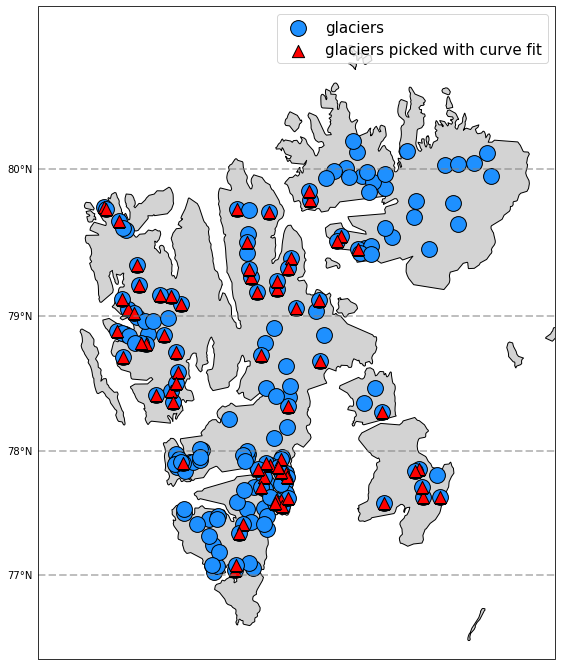

In [9]:
# removes glaciers with crazy scan lines, keep only that are centerline
avg_loc_center = svalbard_glaciers[svalbard_glaciers.GLACIER_NAME.isin(centerlines_glacs)].groupby('GLACIER_NAME').mean()
# avg_loc_center = svalbard_glaciers.groupby('GLACIER_NAME').mean()

fig, ax = plt.subplots(1, figsize=(20,12))

# proj = ccrs.PlateCarree()                       # the projection you want to use, many are supported, 
proj = ccrs.Mercator()                       # the projection you want to use, many are supported, 
                                                # this one is the standard for geographic coordinates
    
ax = plt.axes(projection=proj)                  # sets the projection

ax.add_feature(cartopy.feature.OCEAN            # add ocean feature
               , zorder=0                       # layer where ocean should plot; 0 is base   
               , facecolor='w'                  # color of the ocean
              )           

ax.add_feature(cartopy.feature.LAND             # add continent feature
               , zorder=0                       # layer where continent should plot; 0 is base
               , edgecolor='black'              # coastline color
               , facecolor='lightgray'          # continent color
              )               

# ax.coastlines(resolution='110m')                # the level of resolution to render the drawings, 
                                                # see documentation for more details
                
gl = ax.gridlines(crs=ccrs.PlateCarree()        
                , draw_labels=True              # label coordinates
                , linewidth=2                   # line properties can be changed similar to matplotlib
                , color='gray'
                , alpha=0.5
                , linestyle='--')

gl.xlabels_top = gl.ylabels_right = False                          # where labels shouldn't be
gl.xlines = True                                                  # turn off x-axis
gl.xlocator = mticker.FixedLocator([-180, -90, 0, 90, 180])        # sets longitude tick marks
gl.xformatter = LONGITUDE_FORMATTER                                # set cartopy formatting
gl.yformatter = LATITUDE_FORMATTER

gl.xlabel_style = {'size': 15, 'color': 'gray'}                    # change features about the longitude labels
gl.xlabel_style = {'color': 'red', 'weight': 'bold'}

ax.scatter(avg_loc.POINT_LON.values
           ,avg_loc.POINT_LAT.values               # plots your data points on the axes
        , marker='o'                                 # symbol for data point
        , c='dodgerblue'                               # symbol facecolor
        , edgecolor='black'                          # symbol edgecolor
        , alpha=1
        , s=250# opacity
        , transform=ccrs.PlateCarree()
          ,label='surge type')              # projection to plot data in

ax.scatter(avg_loc_center.POINT_LON.values
           ,avg_loc_center.POINT_LAT.values               # plots your data points on the axes
        , marker='^'                                 # symbol for data point
        , c='red'                               # symbol facecolor
        , edgecolor='black'                          # symbol edgecolor
        , alpha=1
        , s=150# opacity
        , transform=ccrs.PlateCarree()
             ,label='center line data')              # projection to plot data in

ax.set_extent([svalbard_bounding_box['left_lon']-1,
               svalbard_bounding_box['right_lon']+2,
               svalbard_bounding_box['bottom_lat'],
               svalbard_bounding_box['top_lat']+0.5
              ], crs=ccrs.PlateCarree())


# ax.legend(['surge type', 'no surge', 'no surge data', 'center line data'], fontsize=15)
ax.legend(['glaciers', 'glaciers picked with curve fit'], fontsize=15)
fig.savefig('svalbardmap.png', bbox_inches='tight', dpi=300)

In [10]:
svalbard_glaciers[svalbard_glaciers.GLACIER_NAME.isin(centerlines_glacs)]

,GlaThiDa_ID,POLITICAL_UNIT,GLACIER_NAME,SURVEY_DATE,PROFILE_ID,POINT_ID,POINT_LAT,POINT_LON,ELEVATION,THICKNESS,THICKNESS_UNCERTAINTY,DATA_FLAG,REMARKS
749920,2226,SJ,CLASEBREEN: GLITNEFONNA NE,19830425.0,NaN,12017023,79.540955,20.145233,400.0,206,NaN,NaN,NaN
749921,2226,SJ,CLASEBREEN: GLITNEFONNA NE,19830425.0,NaN,12017024,79.542099,20.150284,401.0,201,NaN,NaN,NaN
749922,2226,SJ,CLASEBREEN: GLITNEFONNA NE,19830425.0,NaN,12017025,79.543152,20.155090,404.0,195,NaN,NaN,NaN
749923,2226,SJ,CLASEBREEN: GLITNEFONNA NE,19830425.0,NaN,12017026,79.543686,20.157150,406.0,188,NaN,NaN,NaN
749924,2226,SJ,CLASEBREEN: GLITNEFONNA NE,19830425.0,NaN,12017027,79.544754,20.161865,403.0,180,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3135073,5592,SJ,MONACOBREEN,20170407.0,2,3678,79.516432,12.503565,7.0,0,NaN,NaN,High confidence
3135074,5592,SJ,MONACOBREEN,20170407.0,2,3679,79.516566,12.503513,6.0,0,NaN,NaN,High confidence
3135075,5592,SJ,MONACOBREEN,20170407.0,2,3680,79.516700,12.503461,6.0,0,NaN,NaN,High confidence
3135076,5592,SJ,MONACOBREEN,20170407.0,2,3681,79.516834,12.503410,5.0,0,NaN,NaN,High confidence


In [11]:
# window

In [12]:
# def get_slopes_for_index_window(data, window=50):
def get_slopes_for_index_window(data, n_window=10):
    window = int(data.shape[0]/n_window)
#     gb_50 = data.groupby(data.index // window)
    gb_50 = data.groupby(data.index // window)
    
    start = gb_50.head(1)
    end = gb_50.tail(1)
    
    start_lat = start.POINT_LAT
    start_lon = start.POINT_LON
    end_lat = end.POINT_LAT
    end_lon = end.POINT_LON

    window_length = haversine(start_lon, start_lat, end_lon, end_lat)
    
    thick_1 = start.THICKNESS
    thick_2 = end.THICKNESS
    thick = thick_2.values - thick_1.values
    el = start.ELEVATION.values - end.ELEVATION.values
    thick = el - thick
#     thick = el
    print(thick.shape)

    return np.arctan(thick/window_length), gb_50.ELEVATION.mean().values, gb_50.THICKNESS.mean().values, np.array((data.GLACIER_NAME.values[0],)*thick.shape[0]), np.array(((data.THICKNESS.mean(),)*thick.shape[0]))

data = svalbard_glaciers[svalbard_glaciers.GLACIER_NAME=='VEGAFONNA MARIEBREEN']
x, y, z, n, m = get_slopes_for_index_window(data)
m


(12,)


array([206.28227571, 206.28227571, 206.28227571, 206.28227571,
       206.28227571, 206.28227571, 206.28227571, 206.28227571,
       206.28227571, 206.28227571, 206.28227571, 206.28227571])

In [13]:
s = []
for g in centerlines_glacs:
    
    # TODO:  calculate a window size per g to produce same number of points
    #        per glacier
    
    s.append(get_slopes_for_index_window(
        svalbard_glaciers[svalbard_glaciers.GLACIER_NAME==g]
#         , window=50))
        , n_window=10))


(14,)
(12,)
(12,)
(1,)
(1,)
(1,)
(12,)
(11,)
(11,)


/home/john/anaconda3/envs/glaciers/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


(11,)
(11,)
(12,)
(12,)
(11,)
(11,)
(11,)
(12,)
(11,)
(12,)
(11,)
(13,)
(1,)
(12,)
(11,)
(12,)
(13,)
(11,)
(11,)
(11,)
(11,)
(11,)
(12,)
(12,)
(12,)
(11,)
(12,)
(12,)
(13,)
(11,)
(12,)
(12,)
(12,)
(12,)
(12,)
(11,)
(11,)
(12,)
(13,)
(13,)
(11,)
(12,)
(13,)
(11,)
(13,)
(12,)
(15,)
(11,)
(15,)
(1,)
(13,)
(11,)
(11,)
(11,)
(11,)
(11,)
(12,)
(12,)
(12,)
(11,)


In [14]:
heidi = pd.read_excel('/home/colili/Documents/PhD/project_john/data_set/data_sevestre_benn/Surge_database_heidi.xlsx')
heidi_sv = heidi[heidi.Country=='Svalbard']
heidi_sv['surge'] = heidi_sv['Number of dated surges'].apply(lambda x: 1 if x > 0 else 0)
heidi_sv['thick'] = heidi_sv['ZMAX'] - heidi_sv['ZMIN']

/home/john/anaconda3/envs/glaciers/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/john/anaconda3/envs/glaciers/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [15]:
svalbard_glaciers['lower_name'] = svalbard_glaciers[svalbard_glaciers.GLACIER_NAME.isin(centerlines_glacs)].GLACIER_NAME.apply(lambda x: x.strip().lower())

/home/john/anaconda3/envs/glaciers/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
heidi_sv['lower_name'] = heidi_sv.Glacier_Name.apply(lambda x: x.strip().lower())

/home/john/anaconda3/envs/glaciers/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
surge_label = svalbard_glaciers.merge(heidi_sv)[['lower_name', 'surge']]

In [38]:
surge_label

,lower_name,surge
0,liestolbreen,1
1,liestolbreen,1
2,liestolbreen,1
3,liestolbreen,1
4,liestolbreen,1
...,...,...
87526,monacobreen,1
87527,monacobreen,1
87528,monacobreen,1
87529,monacobreen,1


In [18]:
np.hstack(np.array(s)[:,0]).shape

(761,)

In [19]:
# slopes = pd.DataFrame(np.hstack(s).transpose(), columns=['slope', 'el', 'thick','GLACIER_NAME'])
slopes = pd.DataFrame(np.hstack(s).transpose(), columns=['slope', 'el', 'thick','GLACIER_NAME', 'mean_thick'])
slopes['slope'] = slopes.slope.astype(np.float64)
slopes['thick'] = slopes.thick.astype(np.float64)
slopes['el'] = slopes.el.astype(np.float64)
slopes['mean_thick'] = slopes.mean_thick.astype(np.float64)
slopes['lower_name'] = slopes.GLACIER_NAME.apply(lambda x: x.strip().lower())
slopes.dtypes
print(slopes.shape)
slopes = slopes.merge(surge_label.drop_duplicates(), on='lower_name')
print(slopes.shape)

(761, 6)
(316, 7)


In [20]:
slopes.shape

(316, 7)

In [21]:
slopes.head()

,slope,el,thick,GLACIER_NAME,mean_thick,lower_name,surge
0,NaN,182.0,209.0,LIESTOLBREEN,148.409091,liestolbreen,1
1,0.010746,181.5,206.0,LIESTOLBREEN,148.409091,liestolbreen,1
2,0.050948,167.0,161.5,LIESTOLBREEN,148.409091,liestolbreen,1
3,0.040575,150.0,115.5,LIESTOLBREEN,148.409091,liestolbreen,1
4,0.027406,145.0,113.0,LIESTOLBREEN,148.409091,liestolbreen,1


In [22]:
slopes['detrend_thick'] = (slopes.thick - slopes.mean_thick).abs()

(1.0, 1000.0)

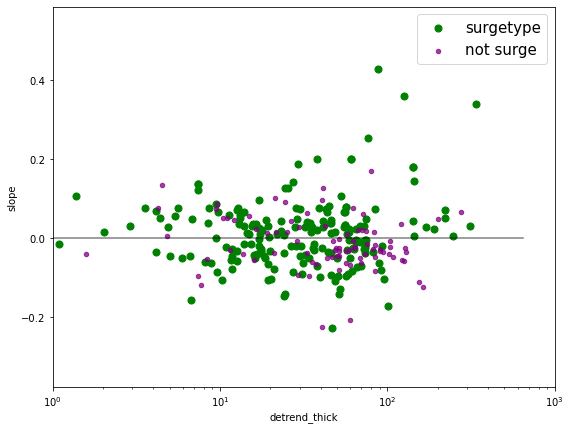

In [23]:
fig, ax = plt.subplots(figsize=(9, 7))
# slopes.plot.scatter(y='slope', x='detrend_thick', color='green', ax=ax, label='surgetype', s=50)
slopes[slopes.surge==1].plot.scatter(y='slope', x='detrend_thick', color='green', ax=ax, label='surgetype', s=50)
slopes[slopes.surge==0].plot.scatter(y='slope', x='detrend_thick', color='purple', ax=ax, label='not surge', alpha=0.75)
ax.legend(fontsize=15)

ax.plot([-10, 650], [0,0], color='black', alpha=0.5)
ax.set_xscale('log')
ax.set_xlim(1e0, 1e3)

In [24]:
# fig, ax = plt.subplots(figsize=(9, 7))
# slopes[slopes.surge==1].plot.scatter(y='slope', x='thick', color='green', ax=ax, label='surgetype', s=50)
# slopes[slopes.surge==0].plot.scatter(y='slope', x='thick', color='purple', ax=ax, label='not surge', alpha=0.75)
# ax.legend(fontsize=15)

# ax.plot([-10, 650], [0,0], color='black', alpha=0.5)

Text(0, 0.5, 'Density')

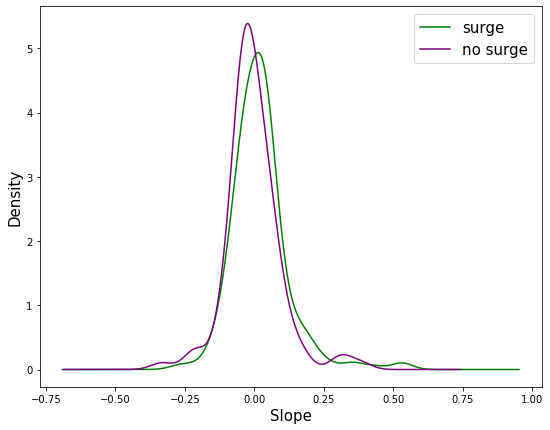

In [25]:
fig, ax = plt.subplots(figsize=(9, 7))
slopes[slopes.surge==1].slope.plot.kde(ax=ax, label='surge', color='green')
slopes[slopes.surge==0].slope.plot.kde(ax=ax, label='no surge', color='purple')
ax.legend(fontsize=15)
ax.set_xlabel('Slope', fontsize=15)
ax.set_ylabel('Density', fontsize=15)
# fig.savefig('kdesurge.png', bbox_inches='tight', dpi=300)

Text(0, 0.5, 'Density')

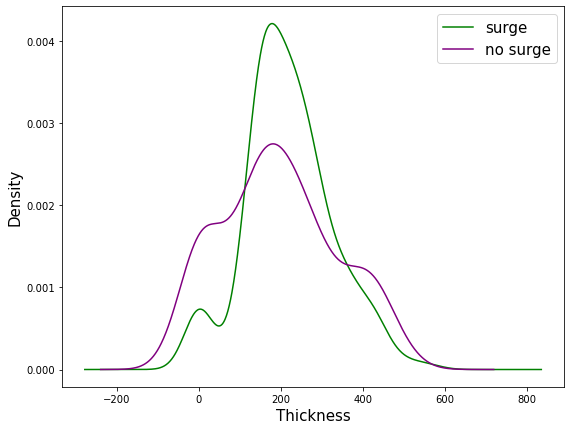

In [26]:
fig, ax = plt.subplots(figsize=(9, 7))
slopes[slopes.surge==1].thick.plot.kde(ax=ax, label='surge', color='green')
slopes[slopes.surge==0].thick.plot.kde(ax=ax, label='no surge', color='purple')
ax.legend(fontsize=15)
ax.set_xlabel('Thickness', fontsize=15)
ax.set_ylabel('Density', fontsize=15)
# fig.savefig('kdesurge_thickness.png', bbox_inches='tight', dpi=300)

In [27]:
slopes.describe()

,slope,el,thick,mean_thick,surge,detrend_thick
count,302.000000,313.000000,316.000000,316.000000,316.000000,316.000000
mean,0.012221,338.004727,210.911253,214.380915,0.667722,48.021063
std,0.102875,211.920931,117.161181,98.310968,0.471777,52.835621
min,-0.333119,22.076923,0.000000,0.000000,0.000000,0.000000
25%,-0.043571,187.000000,147.000000,162.588398,0.000000,12.711833
50%,0.004248,285.000000,203.281818,208.546269,1.000000,34.390410
75%,0.049782,411.500000,279.810606,276.791001,1.000000,62.802236
max,0.542707,1100.101660,556.338710,372.055556,1.000000,336.330379


In [39]:
surge_label

,lower_name,surge
0,liestolbreen,1
1,liestolbreen,1
2,liestolbreen,1
3,liestolbreen,1
4,liestolbreen,1
...,...,...
87526,monacobreen,1
87527,monacobreen,1
87528,monacobreen,1
87529,monacobreen,1


In [52]:
surgemapdata = avg_loc.reset_index()
surgemapdata['lower_name'] = surgemapdata.GLACIER_NAME.apply(lambda x: x.strip().lower())
surgemapdata = surgemapdata.merge(surge_label.drop_duplicates()).merge(slopes.groupby('lower_name').head(1))


In [53]:
surgemapdata.head()

,GLACIER_NAME,GlaThiDa_ID,SURVEY_DATE,POINT_LAT,POINT_LON,ELEVATION,THICKNESS,THICKNESS_UNCERTAINTY,DATA_FLAG,lower_name,surge,slope,el,thick,mean_thick,detrend_thick
0,AAVATSMARKBREEN,2330.000000,2.015051e+07,78.703248,12.096559,330.680000,271.306667,NaN,NaN,aavatsmarkbreen,1,-0.071857,134.375000,205.750000,271.306667,65.556667
1,ABRAHAMSENBREEN,2375.000000,1.983042e+07,79.087028,14.259775,359.459770,275.827586,NaN,NaN,abrahamsenbreen,1,0.029702,436.882353,295.058824,275.827586,19.231237
2,ARNESENBREEN,2267.000000,1.986060e+07,77.824730,18.157952,216.112069,191.844828,NaN,NaN,arnesenbreen,1,0.012930,336.600000,238.000000,191.844828,46.155172
3,BLOMSTRANDBREEN,2423.420128,2.016063e+07,79.052422,12.278587,321.617812,276.791001,10.158881,NaN,blomstrandbreen,1,-0.079746,250.740891,185.340081,276.791001,91.450920
4,BOREBREEN,2321.000000,1.983042e+07,78.453255,13.883708,291.152174,320.097826,NaN,NaN,borebreen,0,-0.017298,508.000000,404.000000,320.097826,83.902174


/home/john/anaconda3/envs/glaciers/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/john/anaconda3/envs/glaciers/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


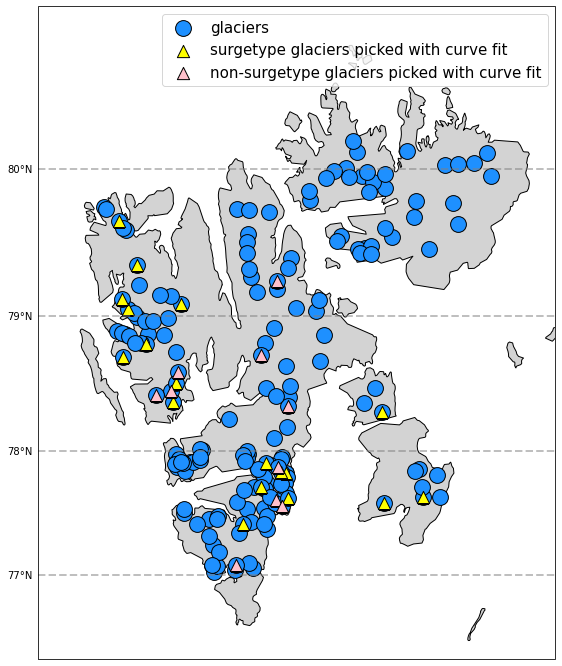

In [62]:
# removes glaciers with crazy scan lines, keep only that are centerline
# avg_loc_center = svalbard_glaciers[svalbard_glaciers.GLACIER_NAME.isin(centerlines_glacs)].groupby('GLACIER_NAME').mean()
# avg_loc_center = svalbard_glaciers.groupby('GLACIER_NAME').mean()

fig, ax = plt.subplots(1, figsize=(20,12))

# proj = ccrs.PlateCarree()                       # the projection you want to use, many are supported, 
proj = ccrs.Mercator()                       # the projection you want to use, many are supported, 
                                                # this one is the standard for geographic coordinates
    
ax = plt.axes(projection=proj)                  # sets the projection

ax.add_feature(cartopy.feature.OCEAN            # add ocean feature
               , zorder=0                       # layer where ocean should plot; 0 is base   
               , facecolor='w'                  # color of the ocean
              )           

ax.add_feature(cartopy.feature.LAND             # add continent feature
               , zorder=0                       # layer where continent should plot; 0 is base
               , edgecolor='black'              # coastline color
               , facecolor='lightgray'          # continent color
              )               

# ax.coastlines(resolution='110m')                # the level of resolution to render the drawings, 
                                                # see documentation for more details
                
gl = ax.gridlines(crs=ccrs.PlateCarree()        
                , draw_labels=True              # label coordinates
                , linewidth=2                   # line properties can be changed similar to matplotlib
                , color='gray'
                , alpha=0.5
                , linestyle='--')

gl.xlabels_top = gl.ylabels_right = False                          # where labels shouldn't be
gl.xlines = True                                                  # turn off x-axis
gl.xlocator = mticker.FixedLocator([-180, -90, 0, 90, 180])        # sets longitude tick marks
gl.xformatter = LONGITUDE_FORMATTER                                # set cartopy formatting
gl.yformatter = LATITUDE_FORMATTER

gl.xlabel_style = {'size': 15, 'color': 'gray'}                    # change features about the longitude labels
gl.xlabel_style = {'color': 'red', 'weight': 'bold'}

ax.scatter(avg_loc.POINT_LON.values
           ,avg_loc.POINT_LAT.values               # plots your data points on the axes
        , marker='o'                                 # symbol for data point
        , c='dodgerblue'                               # symbol facecolor
        , edgecolor='black'                          # symbol edgecolor
        , alpha=1
        , s=250# opacity
        , transform=ccrs.PlateCarree()
          ,label='surge type')              # projection to plot data in

ax.scatter(surgemapdata[surgemapdata.surge==1].POINT_LON.values
           ,surgemapdata[surgemapdata.surge==1].POINT_LAT.values               # plots your data points on the axes
        , marker='^'                                 # symbol for data point
        , c='yellow'                               # symbol facecolor
        , edgecolor='black'                          # symbol edgecolor
        , alpha=1
        , s=150# opacity
        , transform=ccrs.PlateCarree()
             ,label='center line data')              # projection to plot data in

ax.scatter(surgemapdata[surgemapdata.surge==0].POINT_LON.values
           ,surgemapdata[surgemapdata.surge==0].POINT_LAT.values               # plots your data points on the axes
        , marker='^'                                 # symbol for data point
        , c='pink'                               # symbol facecolor
        , edgecolor='black'                          # symbol edgecolor
        , alpha=1
        , s=150# opacity
        , transform=ccrs.PlateCarree()
             ,label='center line data')              # projection to plot data in


ax.set_extent([svalbard_bounding_box['left_lon']-1,
               svalbard_bounding_box['right_lon']+2,
               svalbard_bounding_box['bottom_lat'],
               svalbard_bounding_box['top_lat']+0.5
              ], crs=ccrs.PlateCarree())


# ax.legend(['surge type', 'no surge', 'no surge data', 'center line data'], fontsize=15)
ax.legend(['glaciers', 'surgetype glaciers picked with curve fit', 'non-surgetype glaciers picked with curve fit'], fontsize=15)
fig.savefig('svalbardmap_surgetype.png', bbox_inches='tight', dpi=300)

In [61]:
heidi[heidi.Country=='Svalbard'].dropna()

,Country,RGI_ID,GLIMS_ID,Glacier_Name,Number of dated surges,CENLAT,CENLON,AREA,ZMIN,ZMAX,ZMED,SLOPE,ASPECT,LMAX
0,Svalbard,RGI50.07.01130,G016561E78093N,Kokbreen,0,78.093,16.5613,18.191,160.0,963.0,582.0,11.4,196.0,7636.0
928,Svalbard,RGI50-07.00025,G023512E79401N,Bråsvellbreen Austfonna basin 1,1,79.4014,23.5121,1095.853,1.0,926.0,271.0,4.4,184.0,50954.0
930,Svalbard,RGI50-07.00027,G024554E79593N,Austfonna basin 3,3,79.5931,24.5544,1226.367,2.0,917.0,507.0,9.0,140.0,56487.0
931,Svalbard,RGI50-07.00035,G021342E80037N,Rijpbreen,2,80.0371,21.3418,224.739,13.0,952.0,488.0,7.4,36.0,23042.0
932,Svalbard,RGI50-07.00042,G021497E79894N,Bodleybreen,1,79.8936,21.4968,109.841,7.0,862.0,427.0,8.2,176.0,16494.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1210,Svalbard,RGI50-07.01554,G023718E77811N,Stonebreen,2,77.8108,23.7184,581.764,2.0,474.0,207.0,3.6,65.0,34056.0
1211,Svalbard,RGI50-07.01556,G021928E78413N,Reymondbreen,1,78.4125,21.9282,31.623,19.0,591.0,292.0,8.5,133.0,10277.0
1212,Svalbard,RGI50-07.01560,G019824E78864N,Hochstetterbreen (Hochstatterbreen),1,78.864,19.8244,594.902,11.0,620.0,346.0,3.9,57.0,40919.0
1213,Svalbard,RGI50-07.01564,G018237E79056N,Hinlopenbreen (Oslobreen),2,79.0561,18.2367,330.996,13.0,1640.0,741.0,6.0,77.0,38466.0


In [64]:
surgemapdata.shape

(28, 16)

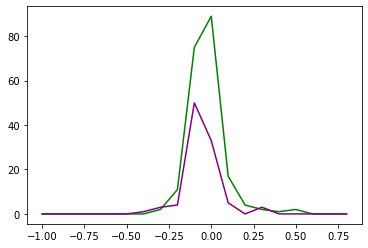

In [28]:
def get_hist(data):
    h, e = np.histogram(a=data, bins=np.arange(-1, 1, 0.1))
    c = h.cumsum()
    return e, h, c

fig, ax = plt.subplots()

surge_type = get_hist(slopes[slopes.surge==1].slope)
notsurge_type = get_hist(slopes[slopes.surge==0].slope)

ax.plot(surge_type[0][:-1], surge_type[1], color='green', label='surge type')
ax.plot(notsurge_type[0][:-1], notsurge_type[1], color='purple', label='NOT surge type')

In [29]:
surge_type

(array([-1.00000000e+00, -9.00000000e-01, -8.00000000e-01, -7.00000000e-01,
        -6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
        -2.00000000e-01, -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
         2.00000000e-01,  3.00000000e-01,  4.00000000e-01,  5.00000000e-01,
         6.00000000e-01,  7.00000000e-01,  8.00000000e-01,  9.00000000e-01]),
 array([ 0,  0,  0,  0,  0,  0,  0,  2, 11, 75, 89, 17,  4,  2,  1,  2,  0,
         0,  0]),
 array([  0,   0,   0,   0,   0,   0,   0,   2,  13,  88, 177, 194, 198,
        200, 201, 203, 203, 203, 203]))

<AxesSubplot:>

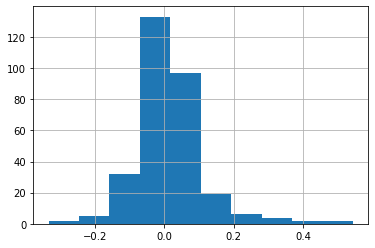

In [30]:
slopes.slope.hist()

<AxesSubplot:>

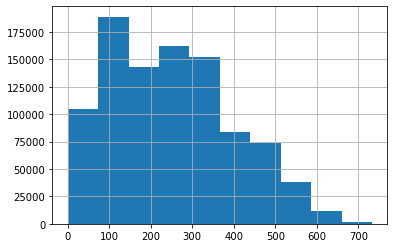

In [31]:
svalbard_glaciers.THICKNESS.hist()

In [32]:
# heidi = pd.read_excel('Surge database heidi.xlsx')
# heidi_sv = heidi[heidi.Country=='Svalbard']
# heidi_sv['surge'] = heidi_sv['Number of dated surges'].apply(lambda x: 1 if x > 0 else 0)
# heidi_sv['thick'] = heidi_sv['ZMAX'] - heidi_sv['ZMIN']

In [33]:
# heidi_sv.head()

<AxesSubplot:xlabel='thick', ylabel='SLOPE'>

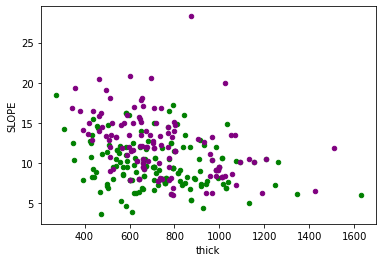

In [34]:
fig, ax = plt.subplots()

heidi_sv[heidi_sv.surge==1].plot.scatter(x='thick', y='SLOPE', c='green',ax=ax)
heidi_sv[heidi_sv.surge==0].plot.scatter(x='thick', y='SLOPE', c='purple',ax=ax)

<AxesSubplot:ylabel='Density'>

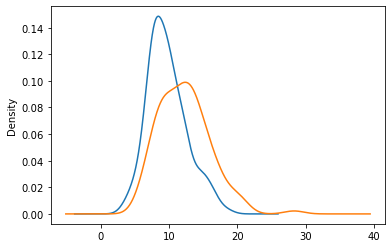

In [35]:
fig, ax = plt.subplots()
heidi_sv[heidi_sv.surge==1].SLOPE.plot.kde(ax=ax, label='surge type')
heidi_sv[heidi_sv.surge==0].SLOPE.plot.kde(ax=ax, label='NOT surge type')

<AxesSubplot:ylabel='Density'>

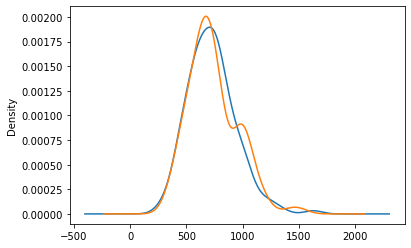

In [36]:
fig, ax = plt.subplots()
heidi_sv[heidi_sv.surge==1].thick.plot.kde(ax=ax, label='surge type')
heidi_sv[heidi_sv.surge==0].thick.plot.kde(ax=ax, label='NOT surge type')

<AxesSubplot:xlabel='POINT_LON', ylabel='POINT_LAT'>

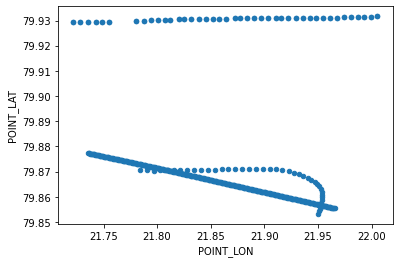

In [37]:
svalbard_glaciers[svalbard_glaciers.GLACIER_NAME=='AMENFONNA'].plot.scatter(x='POINT_LON', y='POINT_LAT')